In [1]:
%pip -q install -U spacy networkx langchain-community chromadb sentence-transformers pypdf matplotlib

import sys, subprocess
subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"], check=True)

import os, re, json, math, time, random, platform, datetime
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
from typing import List, Dict, Tuple

DATA_DIR = "./data_week6"
os.makedirs(DATA_DIR, exist_ok=True)

print("✅ Setup complete.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.5/323.5 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 4.1 MB/s eta 0:0

In [2]:
from pathlib import Path
from langchain_community.document_loaders import PyPDFLoader, TextLoader

corpus_csv_path = os.path.join(DATA_DIR, "corpus.csv")

def build_corpus_csv_from_files():
    CORPUS_DIR = Path("corpus"); CORPUS_DIR.mkdir(exist_ok=True)
    files = [p for p in CORPUS_DIR.iterdir() if p.is_file()]

    try:
        from google.colab import files as colab_files
        print("Upload PDFs/TXTs (or click 'Cancel' to reuse existing ./corpus):")
        uploaded = colab_files.upload()
        for name, data in (uploaded or {}).items():
            (CORPUS_DIR / name).write_bytes(data)
        files = [p for p in CORPUS_DIR.iterdir() if p.is_file()]
    except Exception:
        pass

    docs_text = []
    for p in files:
        try:
            if p.suffix.lower() == ".pdf":
                pages = PyPDFLoader(str(p)).load()
                text = "\n".join([pg.page_content or "" for pg in pages]).strip()
                if text:
                    docs_text.append({"doc_id": p.stem, "text": text})
            elif p.suffix.lower() in [".txt", ".text", ".md"]:
                recs = TextLoader(str(p), encoding="utf-8").load()
                text = "\n".join([r.page_content or "" for r in recs]).strip()
                if text:
                    docs_text.append({"doc_id": p.stem, "text": text})
        except Exception as e:
            print(f"[WARN] Could not read {p.name}: {e}")

    if not docs_text:
        print("No files found; creating demo corpus (professor-style).")
        demo = pd.DataFrame({
            "doc_id": [f"doc{i}" for i in range(1,6)],
            "text": [
                "Method X was introduced by Author A and compared on Dataset D1 with F1=0.78.",
                "Author A collaborated with Author B; Method X improved Metric F1 on D1.",
                "Dataset D2 was used to evaluate Method Y introduced by Author C.",
                "Paper P3 applies Method X to Dataset D2 and reports Accuracy 0.82.",
                "Survey S1 links Method Y, Dataset D2, and Metric AUC."
            ]
        })
        demo.to_csv(corpus_csv_path, index=False)
        return

    df = pd.DataFrame(docs_text)
    df.to_csv(corpus_csv_path, index=False)
    print(f"💾 Saved: {corpus_csv_path} with {len(df)} documents.")

if not os.path.exists(corpus_csv_path):
    build_corpus_csv_from_files()

corpus = pd.read_csv(corpus_csv_path)
print("✅ Corpus loaded:", corpus.shape)
display(corpus.head())


Upload PDFs/TXTs (or click 'Cancel' to reuse existing ./corpus):


Saving NeurIPS-2024-can-large-language-model-agents-simulate-human-trust-behavior-Paper-Conference.pdf to NeurIPS-2024-can-large-language-model-agents-simulate-human-trust-behavior-Paper-Conference.pdf
Saving NeurIPS-2024-richelieu-self-evolving-llm-based-agents-for-ai-diplomacy-Paper-Conference.pdf to NeurIPS-2024-richelieu-self-evolving-llm-based-agents-for-ai-diplomacy-Paper-Conference.pdf
Saving NeurIPS-2024-mdagents-an-adaptive-collaboration-of-llms-for-medical-decision-making-Paper-Conference.pdf to NeurIPS-2024-mdagents-an-adaptive-collaboration-of-llms-for-medical-decision-making-Paper-Conference.pdf
💾 Saved: ./data_week6/corpus.csv with 3 documents.
✅ Corpus loaded: (3, 2)


,doc_id,text
0,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,MDAgents: An Adaptive Collaboration of LLMs fo...
1,NeurIPS-2024-richelieu-self-evolving-llm-based...,Richelieu: Self-Evolving LLM-Based Agents for ...
2,NeurIPS-2024-can-large-language-model-agents-s...,Can Large Language Model Agents Simulate\nHuma...


In [3]:
ENTITY_PATTERNS = {
    "METHOD": r"Method\s+[A-Z][A-Za-z0-9]*",
    "AUTHOR": r"Author\s+[A-Z]",
    "DATASET": r"Dataset\s+[A-Z0-9]+",
    "PAPER": r"Paper\s+[A-Z0-9]+|Survey\s+[A-Z0-9]+",
    "METRIC": r"F1|Accuracy|AUC"
}

def extract_entities(text: str):
    ents = []
    for typ, pat in ENTITY_PATTERNS.items():
        for m in re.finditer(pat, text):
            ents.append((m.group(0), typ, m.start(), m.end()))
    return ents

rows = []
for _, r in corpus.iterrows():
    ents = extract_entities(r["text"])
    for e, typ, s, t in ents:
        rows.append({
            "doc_id": r["doc_id"],
            "entity": e,
            "type": typ,
            "start": s,
            "end": t,
            "span": r["text"][max(0,s-40):min(len(r['text']),t+40)]
        })

ents_df = pd.DataFrame(rows)
print("✅ Entities extracted:", len(ents_df))
display(ents_df.head(10))


✅ Entities extracted: 38


,doc_id,entity,type,start,end,span
0,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method MDAgents,METHOD,8056,8071,key dimensions of LLM decision-making.\nMetho...
1,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method\nMedical,METHOD,23395,23409,ted in Table 9-12 in\nAppendix.\nCategory Meth...
2,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method\nClinical,METHOD,24504,24519,65.3 ±3.9 56.4 ±4.5 56.2 ±6.7\nCategory Metho...
3,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method Avg,METHOD,37515,37525,atively less complex medical knowledge.\nMetho...
4,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method Accuracy,METHOD,84088,84103,ons dataset with GPT-4o mini\n.\nCategory Meth...
5,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method MedQA,METHOD,84986,84998,test sets with GPT-4 (Vision) (in USD)\nMetho...
6,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method Accuracy,METHOD,85503,85518,mpact of Knowledge Enhancement with RAG\nMetho...
7,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method\nMedical,METHOD,87670,87684,for each benchmark and model.\nCategory Metho...
8,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method\nClinical,METHOD,88697,88712,55.0 ±2.0 41.8 ±3.0 44.5 ±2.0\nCategory Metho...
9,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method\nMedical,METHOD,90188,90202,for each benchmark and model.\nCategory Metho...


In [4]:
def sentence_split(text):
    return re.split(r"(?<=[.!?])\s+", text)

edges = []
for _, r in corpus.iterrows():
    for sent in sentence_split(r["text"]):
        sent = sent.strip()
        if not sent:
            continue
        ents = extract_entities(sent)
        for i in range(len(ents)):
            for j in range(i+1, len(ents)):
                e1, t1, *_ = ents[i]
                e2, t2, *_ = ents[j]
                edges.append({
                    "doc_id": r["doc_id"],
                    "head": e1, "type1": t1,
                    "tail": e2, "type2": t2,
                    "sentence": sent
                })

edges_df = pd.DataFrame(edges)
print("✅ Relations extracted:", len(edges_df))
display(edges_df.head(10))


✅ Relations extracted: 14


,doc_id,head,type1,tail,type2,sentence
0,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method\nMedical,METHOD,Method\nClinical,METHOD,Category Method\nMedical Knowledge Retrieval D...
1,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Dataset\nT,DATASET,Accuracy,METRIC,Report Generation\nD.1 Accuracy on entire MedQ...
2,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method Accuracy,METHOD,Accuracy,METRIC,Category Method Accuracy (%)\nSingle-agent\nZe...
3,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method Accuracy,METHOD,Accuracy,METRIC,23\nD.3 Impact of Knowledge Enhancement with R...
4,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method\nMedical,METHOD,Method\nClinical,METHOD,Category Method\nMedical Knowledge Retrieval D...
5,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method\nMedical,METHOD,Accuracy,METRIC,Category Method\nMedical Knowledge Retrieval D...
6,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method\nClinical,METHOD,Accuracy,METRIC,Category Method\nMedical Knowledge Retrieval D...
7,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method\nMedical,METHOD,Method\nClinical,METHOD,Category Method\nMedical Knowledge Retrieval D...
8,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method\nMedical,METHOD,Accuracy,METRIC,Category Method\nMedical Knowledge Retrieval D...
9,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method\nClinical,METHOD,Accuracy,METRIC,Category Method\nMedical Knowledge Retrieval D...


In [5]:
G = nx.Graph()

for _, e in ents_df.iterrows():
    G.add_node(e["entity"], type=e["type"])

for _, ed in edges_df.iterrows():
    G.add_edge(ed["head"], ed["tail"], doc_id=ed["doc_id"], sentence=ed["sentence"])

print(f"✅ Graph built: {len(G.nodes())} nodes | {len(G.edges())} edges")


✅ Graph built: 14 nodes | 6 edges


In [6]:
def detect_seed_entities(query: str):
    seeds = []
    qlow = query.lower()
    for node in G.nodes():
        if node.lower().split()[-1] in qlow:
            seeds.append(node)
    for node, data in G.nodes(data=True):
        if data.get("type") in ("METHOD", "DATASET") and data["type"].lower() in qlow:
            seeds.append(node)
    return list(dict.fromkeys(seeds))

def neighborhood_evidence(seeds, hops=1, max_spans=12):
    spans, seen_edges = [], set()
    for s in seeds:
        if s not in G:
            continue
        nodes = nx.single_source_shortest_path_length(G, s, cutoff=hops).keys()
        for u in nodes:
            for v in G.neighbors(u):
                e = tuple(sorted([u, v]))
                if e in seen_edges:
                    continue
                seen_edges.add(e)
                data = G.get_edge_data(u, v)
                spans.append({
                    "u": u, "v": v,
                    "doc_id": data.get("doc_id"),
                    "sentence": data.get("sentence")
                })
                if len(spans) >= max_spans:
                    return spans
    return spans

def graph_rag(query: str, hops=1):
    seeds = detect_seed_entities(query)
    spans = neighborhood_evidence(seeds, hops=hops)
    return {"seeds": seeds, "spans": spans}

demo_out = graph_rag("Which dataset evaluated Method X with F1?", hops=1)
demo_out


{'seeds': ['Dataset I',
  'Dataset M',
  'Dataset\nT',
  'Paper C',
  'Method MDAgents',
  'Method\nMedical',
  'Method\nClinical',
  'Method Avg',
  'Method Accuracy',
  'Method MedQA',
  'Method DDXPlus',
  'Dataset\nN'],
 'spans': [{'u': 'Dataset\nT',
   'v': 'Accuracy',
   'doc_id': 'NeurIPS-2024-mdagents-an-adaptive-collaboration-of-llms-for-medical-decision-making-Paper-Conference',
   'sentence': 'Report Generation\nD.1 Accuracy on entire MedQA 5-options Dataset\nTo provide a comprehensive evaluation of our approach, we conducted experiments on the entire\nMedQA 5-options dataset using GPT-4o mini.'},
  {'u': 'Accuracy',
   'v': 'Method Accuracy',
   'doc_id': 'NeurIPS-2024-mdagents-an-adaptive-collaboration-of-llms-for-medical-decision-making-Paper-Conference',
   'sentence': '23\nD.3 Impact of Knowledge Enhancement with RAG\nMethod Accuracy (%)\nMDAgents (baseline) 71.8\n+ MedRAG 75.2\n+ Medical Knowledge Initialization 76.0\n+ Moderator’s Review 77.6\n+ Moderator’s Review & M

In [7]:
def assemble_prompt(query, seeds, spans):
    ev_lines = [f"- ({s['doc_id']}) {s['sentence']}" for s in spans]
    return f"""System: Answer using ONLY the evidence and cite (doc_id).
Query: {query}

Seeds: {', '.join(seeds) if seeds else '(none)'}

Evidence:
""" + "\n".join(ev_lines) + "\n\nAnswer:"

print(assemble_prompt("Which dataset evaluated Method X with F1?", demo_out["seeds"], demo_out["spans"]))


System: Answer using ONLY the evidence and cite (doc_id).
Query: Which dataset evaluated Method X with F1?

Seeds: Dataset I, Dataset M, Dataset
T, Paper C, Method MDAgents, Method
Medical, Method
Clinical, Method Avg, Method Accuracy, Method MedQA, Method DDXPlus, Dataset
N

Evidence:
- (NeurIPS-2024-mdagents-an-adaptive-collaboration-of-llms-for-medical-decision-making-Paper-Conference) Report Generation
D.1 Accuracy on entire MedQA 5-options Dataset
To provide a comprehensive evaluation of our approach, we conducted experiments on the entire
MedQA 5-options dataset using GPT-4o mini.
- (NeurIPS-2024-mdagents-an-adaptive-collaboration-of-llms-for-medical-decision-making-Paper-Conference) 23
D.3 Impact of Knowledge Enhancement with RAG
Method Accuracy (%)
MDAgents (baseline) 71.8
+ MedRAG 75.2
+ Medical Knowledge Initialization 76.0
+ Moderator’s Review 77.6
+ Moderator’s Review & MedRAG 80.3
Table 7: Impact of knowledge enhancement on MDAgents performance
We investigated whether simp

/tmp/ipython-input-670650143.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


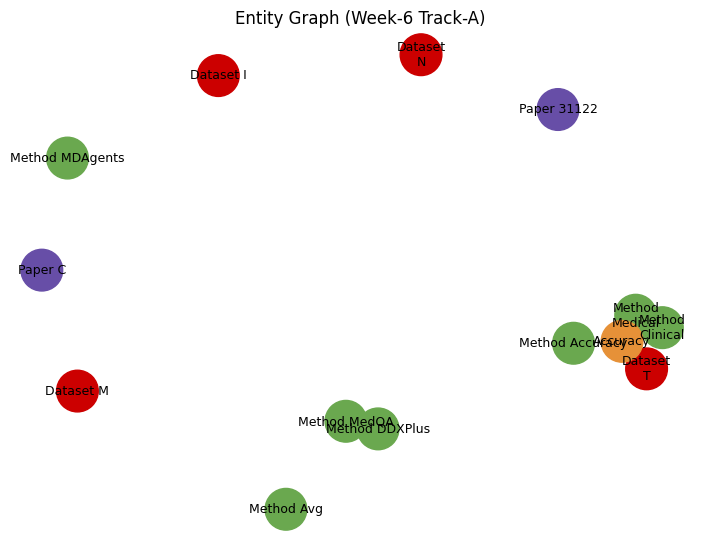

In [8]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G, seed=7)
type_to_color = {"METHOD":"#6aa84f","AUTHOR":"#3c78d8","DATASET":"#cc0000","PAPER":"#674ea7","METRIC":"#e69138"}
node_colors = [type_to_color.get(G.nodes[n].get("type",""), "#999") for n in G.nodes()]

plt.figure(figsize=(7,5))
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=900, font_size=9, edge_color="#bbb")
plt.title("Entity Graph (Week-6 Track-A)")
plt.tight_layout()
plt.show()


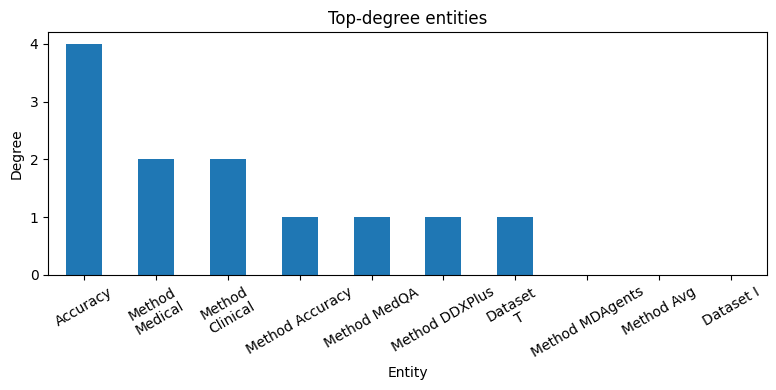

In [10]:
import pandas as pd
deg = dict(G.degree())
top = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:10]
df_deg = pd.DataFrame(top, columns=["entity","degree"])

ax = df_deg.plot.bar(x="entity", y="degree", figsize=(8,4), legend=False, rot=30)
ax.set_title("Top-degree entities")
ax.set_xlabel("Entity")
ax.set_ylabel("Degree")
plt.tight_layout()
plt.show()


In [11]:
cols = ["doc_id","head","type1","tail","type2","sentence"]
display(edges_df[cols].head(12))


,doc_id,head,type1,tail,type2,sentence
0,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method\nMedical,METHOD,Method\nClinical,METHOD,Category Method\nMedical Knowledge Retrieval D...
1,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Dataset\nT,DATASET,Accuracy,METRIC,Report Generation\nD.1 Accuracy on entire MedQ...
2,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method Accuracy,METHOD,Accuracy,METRIC,Category Method Accuracy (%)\nSingle-agent\nZe...
3,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method Accuracy,METHOD,Accuracy,METRIC,23\nD.3 Impact of Knowledge Enhancement with R...
4,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method\nMedical,METHOD,Method\nClinical,METHOD,Category Method\nMedical Knowledge Retrieval D...
5,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method\nMedical,METHOD,Accuracy,METRIC,Category Method\nMedical Knowledge Retrieval D...
6,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method\nClinical,METHOD,Accuracy,METRIC,Category Method\nMedical Knowledge Retrieval D...
7,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method\nMedical,METHOD,Method\nClinical,METHOD,Category Method\nMedical Knowledge Retrieval D...
8,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method\nMedical,METHOD,Accuracy,METRIC,Category Method\nMedical Knowledge Retrieval D...
9,NeurIPS-2024-mdagents-an-adaptive-collaboratio...,Method\nClinical,METHOD,Accuracy,METRIC,Category Method\nMedical Knowledge Retrieval D...


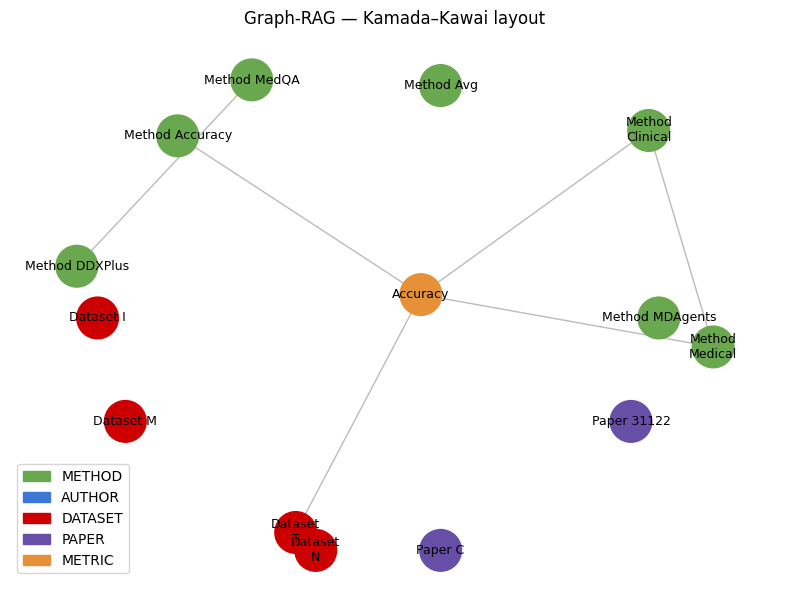

In [13]:
import matplotlib.pyplot as plt
import networkx as nx

type_to_color = {"METHOD":"#6aa84f","AUTHOR":"#3c78d8","DATASET":"#cc0000","PAPER":"#674ea7","METRIC":"#e69138"}
colors = [type_to_color.get(G.nodes[n].get("type",""), "#999") for n in G.nodes()]
pos = nx.kamada_kawai_layout(G, weight=None)

plt.figure(figsize=(8,6))
nx.draw_networkx(
    G, pos,
    with_labels=True, node_color=colors, node_size=900,
    edge_color="#bbb", font_size=9
)
from matplotlib.patches import Patch
handles = [Patch(color=c, label=t) for t, c in type_to_color.items()]
plt.legend(handles=handles, loc="best", frameon=True)
plt.title("Graph-RAG — Kamada–Kawai layout")
plt.axis("off")
plt.tight_layout()
plt.show()


In [14]:
from langchain_community.embeddings import SentenceTransformerEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.schema import Document

lc_docs = [Document(page_content=row["text"], metadata={"doc_id": row["doc_id"]}) for _, row in corpus.iterrows()]

emb = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectordb = Chroma.from_documents(lc_docs, emb, persist_directory="chroma_week6_graph")
retriever_dense = vectordb.as_retriever(search_kwargs={"k": 5})

def baseline_dense(query: str, k: int = 5):
    docs = retriever_dense.get_relevant_documents(query)[:k]
    return [{"doc_id": d.metadata.get("doc_id"), "snippet": d.page_content[:220]} for d in docs]

q_demo = "Which dataset was used to evaluate Method X?"
print("\n[Baseline Dense]")
for e in baseline_dense(q_demo, 5):
    print(f"({e['doc_id']}) {e['snippet']}")

print("\n[Graph-RAG hops=2]")
gr = graph_rag(q_demo, hops=2)
for s in gr["spans"][:5]:
    print(f"({s['doc_id']}) {s['sentence']}")


/tmp/ipython-input-427457341.py:13: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  emb = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


[Baseline Dense]
(NeurIPS-2024-mdagents-an-adaptive-collaboration-of-llms-for-medical-decision-making-Paper-Conference) MDAgents: An Adaptive Collaboration of LLMs for
Medical Decision-Making
Yubin Kim1 Chanwoo Park1 Hyewon Jeong1♮ Yik Siu Chan1
Xuhai Xu1 Daniel McDuff2 Hyeonhoon Lee3
Marzyeh Ghassemi1 Cynthia Breazeal1 Hae Won Park1
1Mas
(NeurIPS-2024-can-large-language-model-agents-simulate-human-trust-behavior-Paper-Conference) Can Large Language Model Agents Simulate
Human Trust Behavior?
Chengxing Xie∗1, 11 Canyu Chen∗2
Feiran Jia4 Ziyu Ye5 Shiyang Lai5 Kai Shu6 Jindong Gu3 Adel Bibi3 Ziniu Hu7
David Jurgens8 James Evans5, 9, 10 Philip H.S. T
(NeurIPS-2024-richelieu-self-evolving-llm-based-agents-for-ai-diplomacy-Paper-Conference) Richelieu: Self-Evolving LLM-Based Agents for AI
Diplomacy
Zhenyu Guan ♢, Xiangyu Kong♣†B, Fangwei Zhong♠†B, Yizhou Wang♡♢
♢ Institute for Artificial Intelligence, Peking University
♣ College of Computer Science, Beijing

[Graph-RAG hops=2]
(NeurIPS-202

/tmp/ipython-input-427457341.py:18: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever_dense.get_relevant_documents(query)[:k]


In [15]:
env = {
    "timestamp": datetime.datetime.now().isoformat(timespec="seconds"),
    "python": platform.python_version(),
    "platform": platform.platform(),
    "packages": {
        "networkx": nx.__version__,
        "numpy": np.__version__,
        "pandas": pd.__version__
    },
    "notes": "Regex-based entity extraction; sentence co-occurrence edges; NetworkX graph; graph neighborhood retrieval."
}
with open("env_rag_graph.json","w") as f: json.dump(env, f, indent=2)
print("✅ Saved env_rag_graph.json")

run_cfg = {
    "data_dir": DATA_DIR,
    "corpus_csv": corpus_csv_path,
    "entity_patterns": ENTITY_PATTERNS,
    "graph": {"nodes": int(len(G.nodes())), "edges": int(len(G.edges()))},
    "retrieval": {"hops_default": 1, "max_spans_default": 12},
    "baseline_dense": {"enabled": True, "k": 5},
}
with open("rag_graph_run_config.json","w") as f: json.dump(run_cfg, f, indent=2)
print("✅ Saved rag_graph_run_config.json")


✅ Saved env_rag_graph.json
✅ Saved rag_graph_run_config.json


In [16]:
import os
DATA_DIR = "./data_week6"
os.makedirs(DATA_DIR, exist_ok=True)

ENT_CSV = os.path.join(DATA_DIR, "entities.csv")
REL_CSV = os.path.join(DATA_DIR, "relations.csv")

ents_to_save = ents_df[["doc_id","entity","type","start","end","span"]].copy()
rels_to_save = edges_df[["doc_id","head","type1","tail","type2","sentence"]].copy()

ents_to_save.to_csv(ENT_CSV, index=False)
rels_to_save.to_csv(REL_CSV, index=False)

print(f"✅ Saved entities → {ENT_CSV} ({len(ents_to_save)} rows)")
print(f"✅ Saved relations → {REL_CSV} ({len(rels_to_save)} rows)")


✅ Saved entities → ./data_week6/entities.csv (38 rows)
✅ Saved relations → ./data_week6/relations.csv (14 rows)


In [18]:
import networkx as nx, os
GRAPHML = os.path.join(DATA_DIR, "graph_week6.graphml")
EDGELIST = os.path.join(DATA_DIR, "graph_week6.edgelist")

nx.write_graphml(G, GRAPHML)
nx.write_edgelist(G, EDGELIST, data=["doc_id","sentence"])
print(f"📦 graph exports saved:\n- {GRAPHML}\n- {EDGELIST}")


📦 graph exports saved:
- ./data_week6/graph_week6.graphml
- ./data_week6/graph_week6.edgelist
